# Prediction based on VEC-GARCH

In [1]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Downloading/unpacking python-dateutil from https://pypi.python.org/packages/33/68/9eadc96f9899caebd98f55f942d6a8f3fb2b8f8e69ba81a0f771269897e9/python_dateutil-2.5.3-py2.py3-none-any.whl#md5=dbcd46b171e01d4518db96e3571810db (from matplotlib)
Downloading/unpacking pytz from https://pypi.python.org/packages/ae/cf/a7442138ad899a7587489641a8923f1e640cafc2d6ffe4e79e5d15cc5b3e/pytz-2016.4-py2.py3-none-any.whl#md5=77752641348a9ee3c064a8bc31fd80ce (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Downloading/unpacking pyparsing!=2.0.4,>=1.5.6 from https://pypi.python.org/packages/47/49/64007b0bc2badabb6521f73939a7611d0620e6d335a9dd5c20e127aea267/pyparsing-2.1.4-py2.py3-none-any.whl#md5=e2dde266aa7707415c10272cdaf63490 (from matplotlib)
Requirem

In [4]:
!pip install yahoo_finance

Downloading/unpacking yahoo_finance
  Running setup.py (path:/tmp/pip_build_root/yahoo-finance/setup.py) egg_info for package yahoo-finance
    
  Running setup.py install for yahoo-finance
    
    Installing yahoo-finance script to /usr/local/bin
  Could not find .egg-info directory in install record for yahoo_finance
Cleaning up...


In [2]:
#generic
%matplotlib inline
from __future__ import print_function

#public open pakcages and methods
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#private pakcages and methods
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter

#for testing
from IPython import display
import platform
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    for d in data_it:
        return_data.append(d[key])
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data = []
    date = []
    for share in share_list:
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data.append(map(float, get_data_by_key(key=data_type, data=hist_data)))
        date.append(get_data_by_key(key='Date', data=hist_data))
    return np.array(stock_data).T, date

In [124]:
def kernel(x, u, eta=1.2, gamma=2.0, p=1.0):
    z = x + gamma * u
    return eta * z / (1.0 + z ** p)

In [23]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

In [129]:
class TDR(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            kernel=kernel,
            delay=5,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            delay (int): time dealy 
            kernel (lambda:) function for development
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.kernel=kernel
        self.delay = delay
        self.middle = np.zeros(shape=self.N_middle)
    
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        x = np.zeros(shape=(N_data, self.N_middle))
        N_delay = N_data / self.delay
        xi = np.log(2.0) # we set theta 1.0 by dimentionless
        
        #initialization
        for i in xrange(1, self.delay):
            I = np.dot(self.W_in, np.r_[1.0, input_data[i]])
            x[i] = np.exp(-xi) * x[i- 1]\
                    + (1.0 - np.exp(-xi)) * self.kernel(x[i - 1], I)
                     
        for delay_i in xrange(1, N_delay):
            for i in xrange(self.delay):
                index = self.delay * delay_i + i
                I = np.dot(self.W_in, np.r_[1.0, input_data[index]])
                x[index] = np.exp(-xi) * x[index - 1]\
                    + (1.0 - np.exp(-xi)) * self.kernel(x[index - self.delay], I)
            
            if index >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[index]))
                X.append(np.r_[1.0, x[index]])
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = x[-self.delay:]
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), x]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data):
        xi = np.log(2.0) # we set theta 1.0 by dimentionless
        output_data = []
        N_data = len(input_data)
        N_delay = N_data / self.delay
        #initalization
        x = self.middle.copy()
        new_x = x.copy()
        for delay_i in xrange(1, N_delay):
            for i in xrange(self.delay):
                index = self.delay * delay_i + i
                I = np.dot(self.W_in, np.r_[1.0, input_data[index]])
                
                if i == 0:
                    past_x = x[-1]
                else:
                    past_x = new_x[i - 1]
                 
    
                new_x[i] = np.exp(-xi) * past_x + (1.0 - np.exp(-xi)) * self.kernel(x[i], I)
                output = self.activation_out(np.dot(self.W_out, np.r_[1.0, new_x[i]]))
                output_data.append(output)
            x = new_x.copy()
            
        return np.array(output_data)

learning_time: 0.0265820026398


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


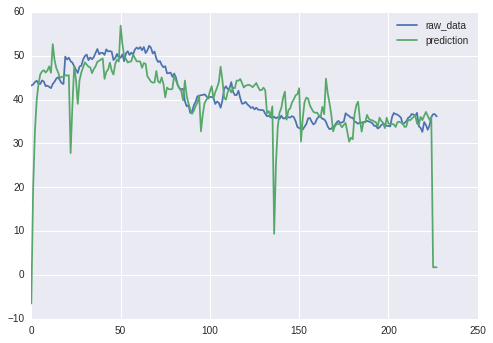

In [130]:
import time

T = len(input_data)
N_middle = T 
tdr = TDR(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = tdr.learning(input_data=input_data, target_data=target_data, start_time=start_time)
elapsed = time.time() - st

print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

prediction time: 0.0112979412079


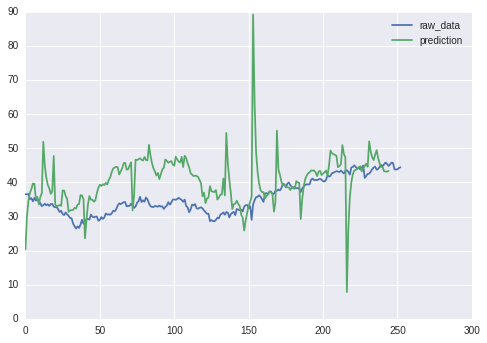

In [131]:
st = time.time()
output_data_pred = tdr.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

In [142]:
class TDR2(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            delay=5,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            delay (int): time dealy 
            kernel (lambda:) function for development
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.delay = delay
        self.middle = np.zeros(shape=self.N_middle)
        
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        x = np.zeros(shape=(N_data, self.N_middle))
        N_delay = N_data / self.delay
        xi = np.log(2.0) # we set theta 1.0 by dimentionless
        
        #initialization
        for i in xrange(1, self.delay):
            I = np.dot(self.W_in, np.r_[1.0, input_data[i]])
            x[i] = np.exp(-xi) * x[i - 1]\
                    + (1.0 - np.exp(-xi)) * self.activation(
                        np.dot(self.W_middle, x[i - 1]) + I)
                     
        for delay_i in xrange(1, N_delay):
            for i in xrange(self.delay):
                index = self.delay * delay_i + i
                I = np.dot(self.W_in, np.r_[1.0, input_data[index]])
                x[index] = np.exp(-xi) * x[index - 1]\
                    + (1.0 - np.exp(-xi)) * (np.dot(self.W_middle, x[index - self.delay]) + I)
            
            if index >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[index]))
                X.append(np.r_[1.0, x[index]])
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = x[-self.delay:]
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), x]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data):
        xi = np.log(2.0) # we set theta 1.0 by dimentionless
        output_data = []
        N_data = len(input_data)
        N_delay = N_data / self.delay
        #initalization
        x = self.middle.copy()
        new_x = x.copy()
        for delay_i in xrange(1, N_delay):
            for i in xrange(self.delay):
                index = self.delay * delay_i + i
                I = np.dot(self.W_in, np.r_[1.0, input_data[index]])
                
                if i == 0:
                    past_x = x[-1]
                else:
                    past_x = new_x[i - 1]              
    
                new_x[i] = np.exp(-xi) * past_x + (1.0 - np.exp(-xi))\
                    * (np.dot(self.W_middle, x[i]) + I)
                output = self.activation_out(np.dot(self.W_out, np.r_[1.0, new_x[i]]))
                output_data.append(output)
            x = new_x.copy()
            
        return np.array(output_data)

learning_time: 0.0781488418579


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


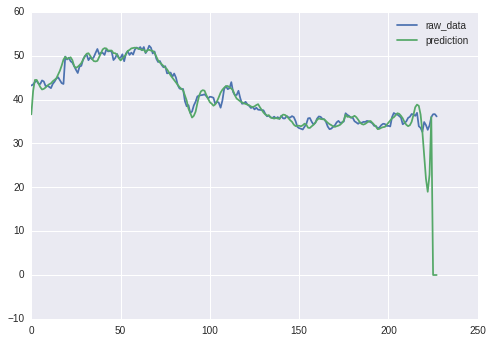

In [143]:
import time

T = len(input_data)
N_middle = T 
tdr = TDR2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = tdr.learning(input_data=input_data, target_data=target_data, start_time=start_time)
elapsed = time.time() - st

print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

prediction time: 0.0322189331055


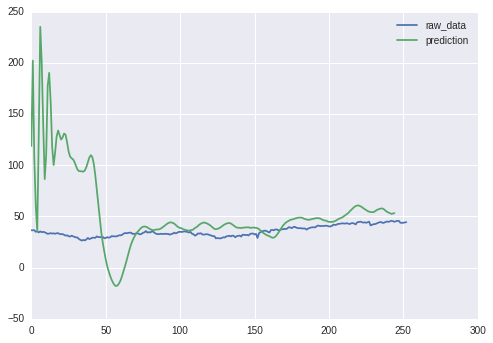

In [144]:
st = time.time()
output_data_pred = tdr.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()